In [1]:
#!/usr/bin/python3
import numpy as np
from math import exp
from numpy.random import binomial,shuffle,seed, choice
import pandas as pd
from IPython.display import display, clear_output
import os

import CompactLSM

import pickle

seedval = 4 # for replicating results

Reservoir Dimension set

In [2]:
nx = 5
ny = 5
nz = 5
N = nx*ny*nz                                          # Reservoir size

N_read = 10                                           # No. of Readout neurons

Important constants related to LIF neuron and synaptic model

In [3]:
global vrest, vth, t_refrac
vrest, vth, t_refrac = 0, 20, 2

tau_m = 32
params_potential = {'C':1, 'g_L':1/tau_m, 'E_L':vrest, 'V_T':vth, 'R_p':t_refrac}

Delay = 1 #constant delay for all synapses in ms

tau_c = 64
C_theta = 5
del_C = 3
n_bits = 32
delta_c = 1
params_conc = {'C_theta':C_theta, 'del_C':del_C, 'tau_c':64, 'nbits':n_bits, 'delta_c':delta_c}

syn_string = "second-order"

sampling_freq = 12.5 # in khz
h = 1 # in ms
α_w = 0.8
time_params = {'h':h, 'Delay':Delay}

Set Reservoir Connections

In [4]:
# Storing the IDs of the neurons
LSM_ID = np.zeros((nx,ny,nz),dtype=np.int64)
l = 0
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            LSM_ID[i,j,k] = l
            l = l + 1

# Storing the synapse connections, and creating the initial weight matrix

k_prob = [0.45, 0.3, 0.6, 0.15]
r_sq = 2**2

W_arr = [3, 6, -2, -2]
W_init = 3
Weights_temp = np.zeros((N,N))

N_in = int(N*0.8)
neuron_type = [ int(i<N_in) for i in range(N)]
seed(seedval)
shuffle(neuron_type) # 1 for excitatory, 0 for inhibitory

synapes = [dict() for i in range(N)]    # an array of dictonaries which store the location of neuron, 
                                        # type of neuron, and the IDs of the neurons it is connected to

for l in range(N):
    loc = CompactLSM.ID_to_ind(nx,ny,nz,l)
    n_type = neuron_type[l]
    cons = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if l != int(LSM_ID[i,j,k]):
                    dist_sq = (loc[0]-i)**2 + (loc[1]-j)**2 + (loc[2]-k)**2
                    k_probl = 0
                    if n_type == 1:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[0]
                        W_init = W_arr[0]
                      else:
                        k_probl = k_prob[1]
                        W_init = W_arr[1]
                    else:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[2]
                        W_init = W_arr[2]
                      else:
                        k_probl = k_prob[3]
                        W_init = W_arr[3]

                    probability = k_probl* exp(-1*dist_sq/r_sq)
#                     print(probability)
                    check = binomial(1,probability)
                    if check == 1:
                        cons.append(int(LSM_ID[i,j,k]))
                        Weights_temp[l,int(LSM_ID[i,j,k])] = W_init    
    synapes[l] = {"Location":loc, "Neuron_type":n_type, "connections":cons}

global Weights
Weights = Weights_temp * α_w
print("Total synapse:", len(np.argwhere(Weights!=0)), 
        ",E --> E :", len(np.argwhere(Weights==W_arr[0] * α_w)), 
        ",E --> I:",len(np.argwhere(Weights==W_arr[1] * α_w)),
        ",I --> E/I:",len(np.argwhere(Weights==W_arr[2] * α_w)))
i = 64
print("Total Connections: for neuron {}:{}, {}".format(i,synapes[i]["Neuron_type"],synapes[i]["connections"]) )
Weights[1,2]

Total synapse: 1130 ,E --> E : 769 ,E --> I: 105 ,I --> E/I: 256
Total Connections: for neuron 64:1, [19, 62, 83, 84, 89, 93, 97, 109, 114, 118]


2.4000000000000004

Set Readout neuron initial Weights

In [5]:
All_labels = [str(x) for x in range(10)]
# N_read = 10                                           # No. of Readout neurons

Weights_temp_readOut = -8 + 16 * np.random.rand(N_read, N) # random weight initialization


synapes_read = []        # an array of dictonaries which store the label of neuron, 
                                                      # and the IDs of the neurons it is connected to

for l in range(N_read):
    label = All_labels[l]
    synapes_read.append(label)

Weights_readOut = Weights_temp_readOut

In [6]:
# creating file location and label arrays for train and validate

base = 'PreProcessing/trainBSA'
os.listdir(base)

train_Labels = []
file_name_List = []

for human in os.listdir(base):
    base_up = base + '/' + human
    for train_sample in os.listdir(base_up):
        train_Label = train_sample[0:2]
        file_loc = base_up + '/' + train_sample
        file_name_List.append(file_loc)
        train_Labels.append(train_Label)


seedval = 2
seed(seedval)
shuffle(train_Labels)
seed(seedval)
shuffle(file_name_List)

total_size = len(train_Labels)
train_size = int(total_size*0.8)

validate_Labels = train_Labels[train_size:total_size]
validate_file_list = file_name_List[train_size:total_size]

train_Labels = train_Labels[0:train_size]
train_file_list = file_name_List[0:train_size]

### Finding input neurons to reservoir current and then using the spike train to find the current input to the reservoir

In [7]:
L = 78
Fin = 4
reservoir_ID = [i for i in range(N)]
seedval = 4
seed(seedval)
Input_CXNs = choice(reservoir_ID, size = (L,Fin))
sign_win_matrix = (binomial(1,1/2, size = (L, Fin)) - 0.5)*2
# Input_CXNs * sign_win_matrix

In [8]:
# print("Input neurons =",L)
print("Size of Reservoir =",nx,"X",ny,"X",nz,",Total total neurons =",N)
print("Total no.of read out neurons =",N_read)

Size of Reservoir = 5 X 5 X 5 ,Total total neurons = 125
Total no.of read out neurons = 10


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (6.4 * 3, 4.8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.titlesize':'xx-large'}
pylab.rcParams.update(params)

## Code for Reservoir Visulaization

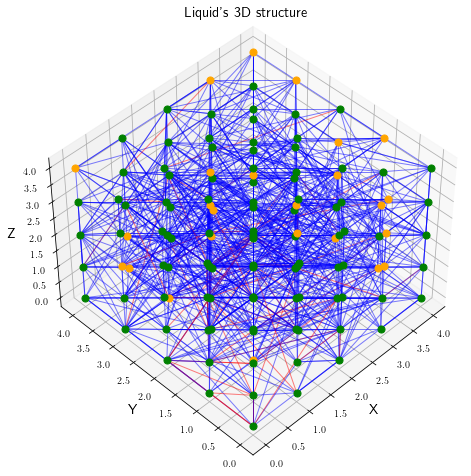

In [10]:
from matplotlib import pyplot as plt
fig_w = 10
fig_h = 8

elev_ang = 45
azim_ang = -135

marker_size = 50

p = 1

fig = plt.figure() # creates the figure for the following plots
fig.set_size_inches(fig_w,fig_h, forward=False) #Set the figure size
ax = fig.add_subplot(111, projection='3d') # setup to only one


for ID in range(N):
    location = synapes[ID]['Location']
    x = location[0]
    y = location[1]
    z = location[2]
    Neuron_tp = synapes[ID]['Neuron_type']
    if Neuron_tp == 1:
        ax.scatter(x,y,z, c = 'green', s = marker_size)
    else:
        ax.scatter(x,y,z, c = 'orange', s = marker_size)

    conns = synapes[ID]['connections']
    syns = len(conns)
    prob = binomial(1,p)
    if prob == 1:
        for i in range(syns):
            x1,y1,z1 = CompactLSM.ID_to_ind(nx,ny,nz,conns[i])
            
            if Weights[ID,i] > 0:
                colour = '#FF0000'
            else:
                colour = '#0000FF'
            ax.plot([x, x1], [ y, y1], [ z, z1], color=colour, linewidth=1, alpha = 0.5)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title("Liquid's 3D structure")

ax.view_init(elev=elev_ang, azim=azim_ang)

plt.show()

### Generating Raster Plots

In [11]:
### A single run

## Loading the best weights
Weights_readOut_fromCsv = pd.read_csv("weights_first_order_best_acc.csv", sep=",", header=None)
Weights_readOut = Weights_readOut_fromCsv.to_numpy()
Weights_readOut_fromCsv = Weights_readOut_fromCsv.iloc[1:, 1:]
Weights_readOut = Weights_readOut_fromCsv.to_numpy()

Input_gen_func = CompactLSM.Input_current_gen(validate_file_list,
                                                syn_string,
                                                N,
                                                time_params,
                                                Input_CXNs,
                                                sign_win_matrix,
                                                training=True,
                                                train_Labels=validate_Labels)
i=-1

In [16]:
# Run this cell mutiple times if different input needed
In_app, L, M, validate_Label,input_num, In_neurons = next(Input_gen_func)      # Generates next input   
[Reservoir_potential, Reservoir_Spikes] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app, 
                                                                            params_potential, Weights, syn_string)

Readout_potential, Readout_Spikes, trained_weights = CompactLSM.readOut_response(N_read,N, Delay, synapes, M,
                                                                                            h, Reservoir_Spikes, 
                                                                                            params_potential,params_conc,
                                                                                            Weights_readOut,syn_string,
                                                                                            training=False,train_ids=[validate_Label])

Weights_readOut = trained_weights

class_out_label, class_out_idx,no_of_spikes= CompactLSM.classifier(Readout_Spikes,synapes_read)
i = i+1

print('Predicted Label:',class_out_label,'Actual Label:',validate_Label)

data = pd.read_csv(validate_file_list[i], sep=",", header=None)
data_as_numpy = data.to_numpy()
Input_Spikes = data_as_numpy.transpose()   # Single Sample input

Predicted Label: 7 Actual Label: 7


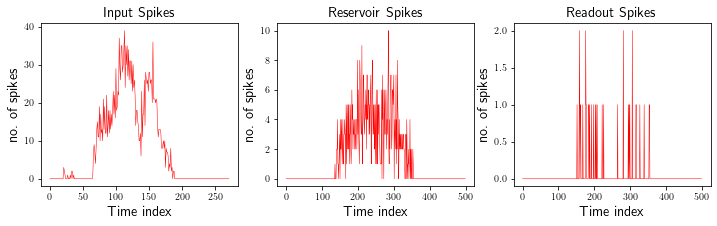

In [17]:
# Plotting Total no.of spikes v/s time
plt.figure(1,figsize=(12,3))

plt.title('Spikes v/s Time')
plt.subplot(1,3,1)
x = np.sum(Input_Spikes,0)
plt.plot(x,'r',linewidth = 0.5)
plt.ylabel('no. of spikes')
plt.xlabel('Time index')
plt.title('Input Spikes')

plt.subplot(1,3,2)
x = np.sum(Reservoir_Spikes,0)
plt.plot(x,'r',linewidth = 0.5)
plt.ylabel('no. of spikes')
plt.xlabel('Time index')
plt.title('Reservoir Spikes')

plt.subplot(1,3,3)
x = np.sum(Readout_Spikes,0)
plt.plot(x,'r',linewidth = 0.5)
plt.ylabel('no. of spikes')
plt.xlabel('Time index')
plt.title('Readout Spikes')

plt.show()

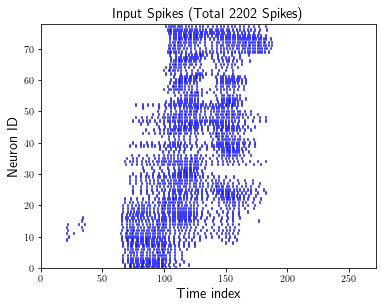

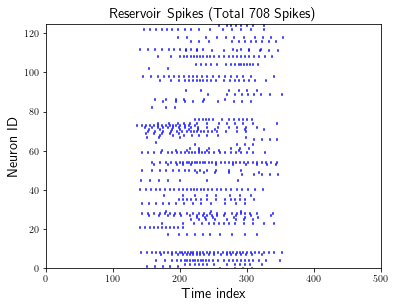

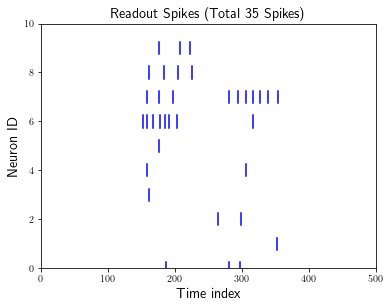

In [18]:
fig_s = (6,4.5)
plt.figure(figsize=fig_s)
CompactLSM.plot_spikes(Input_Spikes,"Input Spikes (Total {:d} Spikes)".format(int(np.sum(Input_Spikes))))
plt.figure(figsize=fig_s)
CompactLSM.plot_spikes(Reservoir_Spikes,"Reservoir Spikes (Total {:d} Spikes)".format(int(np.sum(Reservoir_Spikes))))
plt.figure(figsize=fig_s)
CompactLSM.plot_spikes(Readout_Spikes,"Readout Spikes (Total {:d} Spikes)".format(int(np.sum(Readout_Spikes))))